# Roadmap for algorithm development

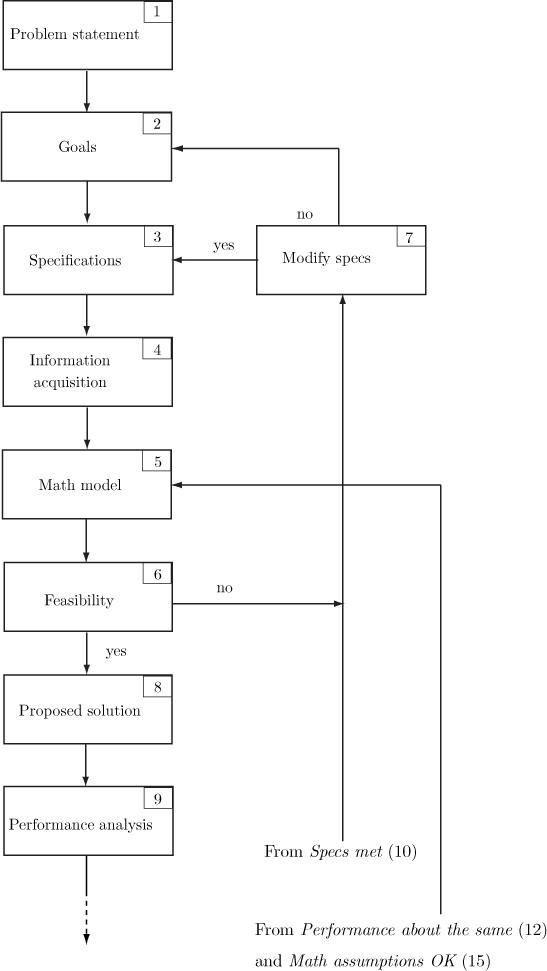

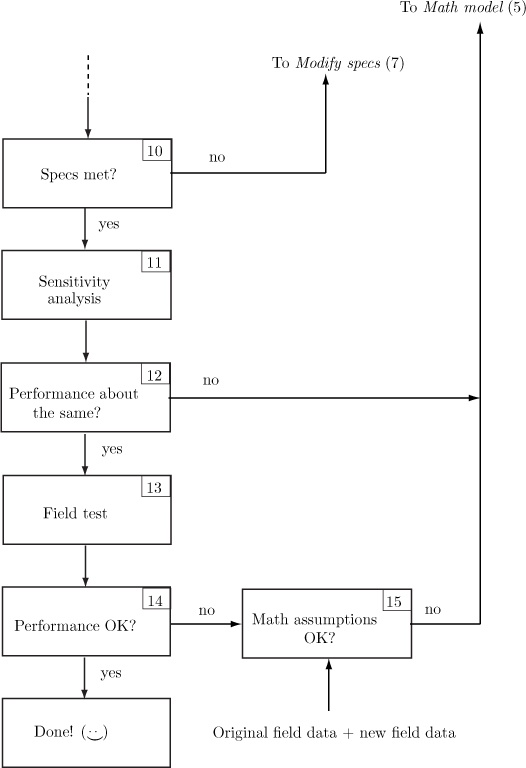

### 1. Problem Statement:
Design Image Processing Algorithm to filter out Salt-and-Pepper Noise from (Image + Noise) array.
Ideal result is to get clean Image from (Image + Noise) array.

### 2. Goals:
Exceed the Performance of existing Salt-and-Pepper Noise filtration methods (Need Performance Comparison Study of the existing methods).

Or

Get acceptable Performance of suggested filtration algorithm provided that its computational complexity allows real-time operation on target platform. (Need to clarify: What is acceptable performance? What perfomance metric should be used? What are target platform limitations?)

### 3. Specifications:
No other specs were given yet.

Q-s: 
1. Do you have baseline algorithm(currently accepted as the best)?
1. What problems with the baseline algorithm do you have so far?

### 4. Information Acquisition:
Q-s: 
1. What is image resolution?
1. Is it RGB or grayscale?
1. Is it allowed to use several consequtive frames during processing? If yes, then how many?
1. How much computational power is available?
1. Should the algorithm to be adaptive?


### 5. Mathematical Model Selection:
Obtain and analyze field data to clarify Math Model Parameters.

##### Mathematical Model Parameters:
1. Stationarity of data
2. Signal power spectral densities
3. Noise power spectral densities
4. Signal PDF
5. Noise PDF
6. Sources of interferences
7. Sources of data artifacts
8. Expected SNRs
9. Sensors limitations


##### Signal Model:
Images typical for surveillance systems.
Signal Model: Real 2D Signal
or
3D Signal (X-Y-Time) or (X-Y-C)
or
4D Signal (X-Y-C-Time)


##### Noise Model:
Noise Model: Salt-and-Pepper Noise
TODO: add math noise model descr.

##### Overall Data Model:
D(x,y) = I(x,y) + N(x,y)

##### Other Impairments Models:
No other impairments.

### 6. Feasibility Study:
An assessment of the best possible performance that is achievable by any algorithm.
It is hard to estimate the best possible performance for this task.
TODO: Look it up in the existing papers.

### 7. Specification Modifications (if necessary):
No modifications.

### 8. Proposed Solution:
Possible approaches:
1. Image Filter (Image Signal Estimator)
2. Pixel-by-pixel Noise Detector followed by Image Filter applied only to pixels with detected noise.

Steps TODO:
1. Make Model
2. Select Performance Criterion (Metric)
3. Make comparative study of the existing solution
4. Try new approaches (Volterra NN?)

### 9. Performance Analysis:
Always do a computer simulation first.

### 10. Are specifications met?:

### 11. Sensitivity Analysis:

### 12. Is Performance during Sensitivity Analysis still acceptable?:

### 13. Field Test:

### 14. Is Performance during Field Test still acceptable?:

### 15. Are Math Assumptions still correct during Field Tests?


In [1]:
#% matplotlib inline
import numpy as np
from skimage import data, img_as_float, img_as_ubyte, exposure, io, color
from skimage.io import imread
from skimage.exposure import cumulative_distribution
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
#from skimage.measure import compare_psnr
from skimage.util import random_noise
from skimage.color import rgb2gray
from PIL import Image, ImageEnhance, ImageFilter
from scipy import ndimage, misc
import matplotlib.pylab as pylab
# for median filter
from skimage.filters.rank import median
from skimage.morphology import disk


In [2]:
# Functions
def plot_gray_image(ax, image, title):
    ax.imshow(image, cmap=pylab.cm.gray),
    ax.set_title(title), ax.axis('off')
    #ax.set_adjustable('box-forced')
    ax.set_adjustable('box')

In [3]:
# from scipy import signal, misc, ndimage
# from skimage import filters, feature, img_as_float
from scipy import signal
from skimage import filters
# Box Filter
def boxFilter(I, r):
    maskSize = 2*r+1
    Mask = np.ones((maskSize,maskSize))
    N = signal.convolve2d(I, Mask)#, boundary='wrap'
    N = N[r:-r,r:-r]
    return N


# Guided Filter
def guidedFilter(I,p,r = 5,eps = 0.1):
    # guidedFilter(I,p,r,eps)
    sizeI = np.shape(I)
    heightI = sizeI[0]
    widthI = sizeI[1]
    print(sizeI)
    print(heightI)
    print(widthI)
    
    Ones = np.ones((heightI,widthI))
    #maskSize = 2*r+1
    #Mask = np.ones((maskSize,maskSize))
    #N = signal.convolve2d(Ones, Mask)#, boundary='wrap'
    #N = N[r:-r,r:-r]
    N = boxFilter(Ones, r)
    
    #dbg: meanIbf = boxFilter(I, r)
    mean_I = boxFilter(I, r)/N
    mean_p = boxFilter(p, r)/N
    mean_Ip = boxFilter(I*p, r)/N
    cov_Ip = mean_Ip - mean_I*mean_p
    
    mean_II = boxFilter(I*I, r)/N
    var_I = mean_II - mean_I*mean_I
    
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I

    mean_a = boxFilter(a, r) / N
    mean_b = boxFilter(b, r) / N

    q = mean_a*I + mean_b
    
    #dbg sizeN = np.shape(N)
    #dbg print(sizeN)
    
    return q

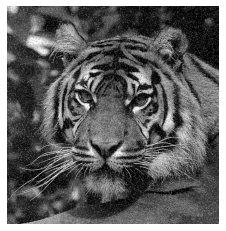

[[196 162 255 192 184 206 184 191 202 188 211 211]
 [168 206 183 194 193 185 205 206   0  17 189 218]
 [179 199 185 190 205 197 199 198 205 217 216   6]
 [180 185 201 173 198 194 210 255 207 213 195 220]
 [192   4 186 222 216 196 209 206 248 224 234 209]
 [184 181 185 188 188 199 200 218 246 206   0 215]
 [165 217 187 196 255   8 204 205   4 255 201 203]
 [184 180 181 190 192 207 204 198   0 196 217 224]
 [  0 178 186 183 198 189 208 204 197 205 215 210]
 [177 179 182 191   0 204 184 188 203 213 255   0]
 [154 160  19 172 189   0 206 195 192 196 196 208]
 [170 183 159 181 189 166   7 184 198 214   2 203]]


In [13]:
import copy

# open image
image = (rgb2gray(imread('./images/tiger_face.jpeg'))*255+0.5).astype(np.uint8)
# image2 = (rgb2gray(imread('./images/tiger_face.jpeg'))).astype(np.uint8)
imageD = image.astype(np.double)

# open noisy image
# noisy_image = ((imread('./images/tiger_face_salt_and_pepper_D10.jpeg'))*255+0.5).astype(np.uint8)
noisy_image = (imread('./images/tiger_face_salt_and_pepper_D10.jpeg')).astype(np.uint8)

pylab.figure()
#pylab.imshow(F, cmap=pylab.cm.gray), pylab.axis('off'), pylab.show()
# pylab.gray()
pylab.imshow(noisy_image, cmap=pylab.cm.gray), pylab.axis('off'), pylab.show()
print(noisy_image[0:12,0:12])
# print(noisy_image2[0:12,0:12])


(768, 748)
768
748


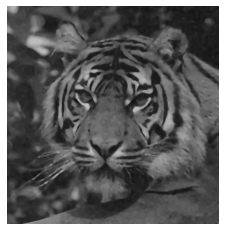

[[183.61451578 185.13604613 186.69416838 188.7215126  188.40992165
  189.2997305  188.82527908 191.05082445 187.16359107 187.09433699
  190.83819607 195.31216534]
 [177.15776974 182.96925306 184.6063562  185.86815654 187.40917206
  189.40174347 188.03546867 190.78046272 187.87830856 188.0474993
  192.02836368 197.90906131]
 [176.72432235 182.39765166 183.97879244 187.15486946 186.80622727
  188.8821312  187.7308272  189.11849125 187.43140613 187.60065501
  191.39125447 198.35081396]
 [176.35626941 179.50344587 182.26273468 184.53363545 186.10999954
  187.28187925 187.40493556 189.25639276 188.03613273 188.44511903
  193.57946262 200.66593898]
 [174.82105877 177.88808348 181.5080249  183.69180546 183.48247844
  186.4175201  185.95009291 189.00170216 188.22148783 188.89834136
  192.90882026 199.90053614]
 [173.43314476 176.43131301 179.03331205 181.25022168 181.9337648
  185.59574072 185.41842338 188.6229518  188.18379092 189.0966331
  193.14010349 200.05129949]
 [171.94409094 173.830841

In [14]:
# add noise
# noise = np.random.random(image.shape)
# noisy_image = copy.deepcopy(image)
# noisy_image[noise > (0.5+0.25)] = 255
# noisy_image[noise < (0.5-0.25)] = 0
noisy_imageD = noisy_image.astype(np.double) 

sq9 = np.ones((9, 9))
image_mf = median(noisy_image, sq9)
image_mfD = image_mf.astype(np.double)

#F = guidedFilter(noisy_image,image_mf21)
F = guidedFilter(image_mfD,noisy_imageD)

pylab.figure()
#pylab.imshow(F, cmap=pylab.cm.gray), pylab.axis('off'), pylab.show()
# pylab.gray()
pylab.imshow(F, cmap=pylab.cm.gray), pylab.axis('off'), pylab.show()

print(F[0:12,0:12])


In [79]:
# debug

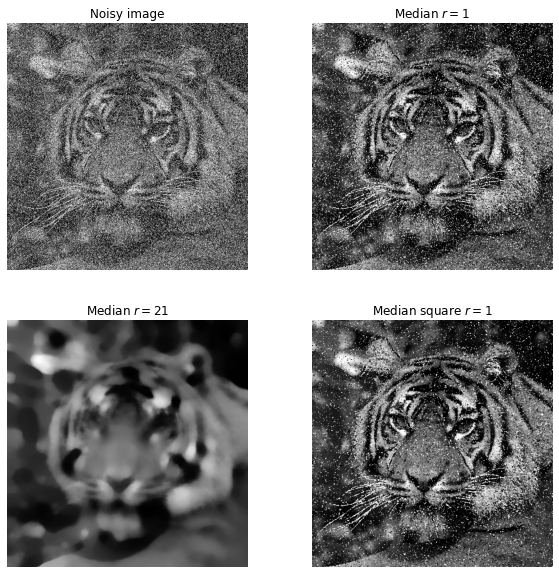

In [30]:
# for all images in folder
# open image
image = (rgb2gray(imread('./images/748px-Tiger_Face_(10971343685).jpg'))*255).astype(np.uint8)
noise = np.random.random(image.shape)

# add noise
noisy_image = image
noisy_image[noise > (0.5+0.25)] = 255
noisy_image[noise < (0.5-0.25)] = 0

# apply filter(s)
sq3 = np.ones((3, 3))
image_mf1 = median(noisy_image, disk(1))
image_mf_sq3 = median(noisy_image, sq3)
image_mf5 = median(noisy_image, disk(5))
image_mf9 = median(noisy_image, disk(9))
image_mf21 = median(noisy_image, disk(21))

# show pictures
fig, axes = pylab.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes1, axes2, axes3, axes4 = axes.ravel()
plot_gray_image(axes1, noisy_image, 'Noisy image')
plot_gray_image(axes2, image_mf1, 'Median $r=1$')
#plot_gray_image(axes4, image_mf5, 'Median $r=5$')
plot_gray_image(axes4, image_mf_sq3, 'Median square $r=1$')
#plot_gray_image(axes3, image_mf9, 'Median $r=9$')
plot_gray_image(axes3, image_mf21, 'Median $r=21$')

# calculate error for noised and filtered images



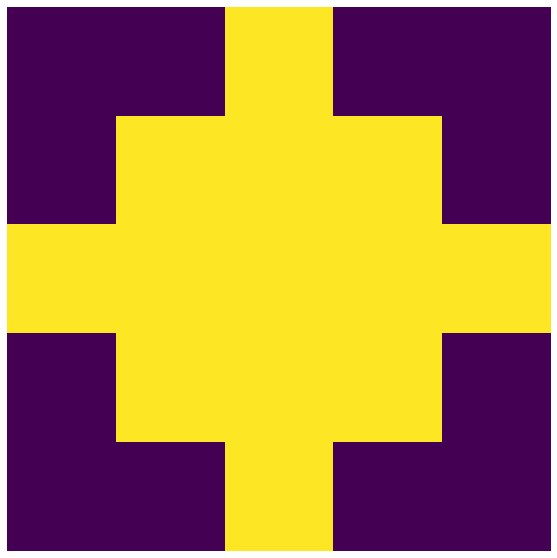

(<matplotlib.image.AxesImage at 0x1486b43af40>, (-0.5, 4.5, 4.5, -0.5), None)

In [8]:

pylab.figure(figsize=(10,10))
pylab.imshow(disk(2)), pylab.axis('off'), pylab.show()

NameError: name 'eps' is not defined

In [ ]:
# TODO:
#> Write guided filter implementation
# Write performance comparison
# Write Denoising methods review (methods pros and cons)
# Create Voltera NN (VNN) in pytorch
# Train VNN in pytorch
# Estimate VNN Performance